# Taichung DE forecast with Neural Network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
plt.style.use('fivethirtyeight')

# Visualizing Data

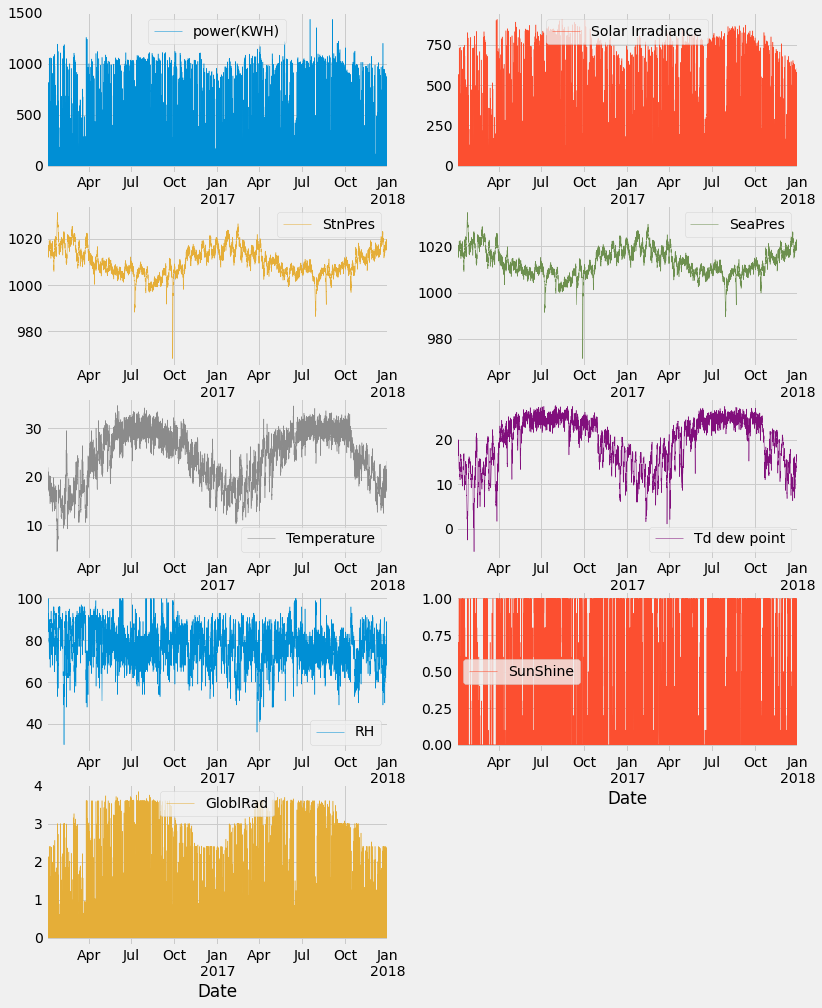

In [2]:
# quick look data
data = pd.read_csv('data\Taichung_Power_Weather.csv', parse_dates=['Date'], index_col='Date')
# visualizing data
data.plot(subplots=True, linewidth=0.5, layout=(5, 2), figsize=(12, 16),
          sharex=False, sharey=False)
plt.show()

# Create lag.

In [3]:
# Creating time-lagged features
def create_lags(df, col ,N):
    for i in N:
        df[col+'_Lag_' + str(i)] = df[col].shift(i)
    return df

for col in data.columns:
    data_lag=create_lags(data, col,[1,24])

data_lag.dropna(inplace=True)

# split train, test data.

Last 4 month to validation.

In [4]:
# choose day time
daytime_idx = (6<= data_lag.index.hour) & (data_lag.index.hour<= 18)
# choose feature and target
Feature = data_lag.loc[daytime_idx,'power(KWH)_Lag_1':]
Target = data_lag.loc[daytime_idx, ['power(KWH)']]
# Split train and test data
X_train, X_test, y_train, y_test = Feature[:'2017-08-31'], Feature['2017-09-01':], Target[:'2017-08-31'], Target['2017-09-01':]

# Normalize

Norm value: min = 0, max = 1

In [5]:
# Normalize
scale = MinMaxScaler()
X_train_norm = scale.fit_transform(X_train)
y_train_norm = scale.fit_transform(y_train)

# Build Model

In [6]:
# build model
def build_model(in_shape):
    model = Sequential([
    Dense(64, activation='relu', input_shape=(in_shape, )),
    Dense(64, activation='relu'),
    Dense(1,  activation='relu')])

    optimizer = keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_squared_error'])
    return model
         

model = build_model(X_train_norm.shape[1])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1216      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________
None


# Model Train

In [7]:
# The patience parameter is the amount of epochs to check for improvement
callback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")

history = model.fit(X_train_norm, y_train_norm, epochs=1000, 
                    validation_split = 0.2, verbose=1, callbacks=[callback])

Epoch 1/1000
198/198 [==============================] - 1s 3ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 2/1000
198/198 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 3/1000
198/198 [==============================] - 0s 1ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/1000
198/198 [==============================] - 0s 1ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/1000
198/198 [==============================] - 0s 1ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 6/1000
198/198 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 7/1000
198

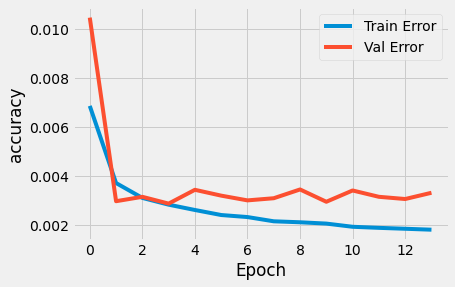

In [8]:
# Display training progress by printing a single dot for each completed epoch

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label='Val Error')
    plt.legend()
    plt.show()

plot_history(history)

# Visualizing Results

In [9]:
X_test_norm = scale.fit_transform(X_test)
y_test_norm = scale.fit(y_test)
y_predict_norm = model.predict(X_test_norm).flatten().reshape(-1,1)

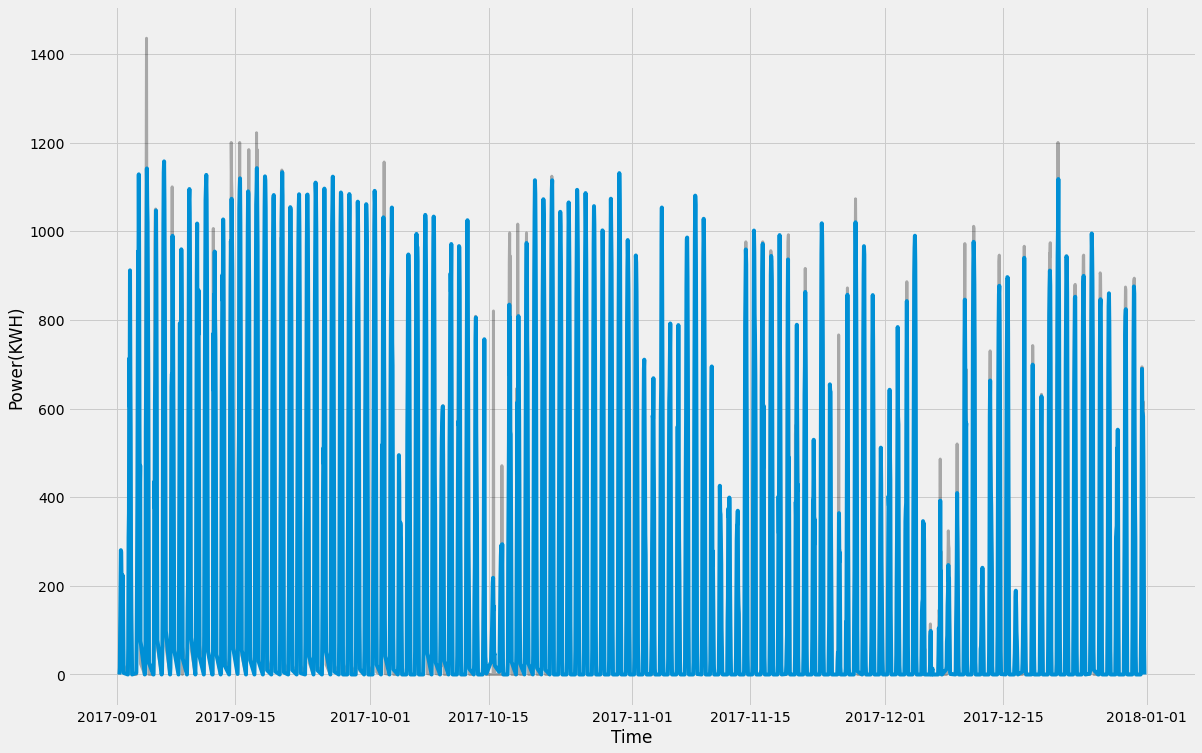

In [10]:
y_predict = scale.inverse_transform(y_predict_norm)
# visualizing predict
fig, ax = plt.subplots(figsize=(18,12))
ax.plot(y_test, color='k', alpha=.3, lw=3)
ax.plot(y_test.index, y_predict)
ax.set(xlabel="Time", ylabel="Power(KWH)")
plt.show()

# Model Score

In [11]:
def MRE(x,y):
    return np.nanmean(np.abs((x-y)/np.max(x)))

def print_results(y_test, y_predict):
    print('Root mean squared error:{:.4f}'.format(np.sqrt(mean_squared_error(y_test,y_predict))))
    print('Mean absolute error:{:.4f}'.format(mean_absolute_error(y_test,y_predict)))
    print('Mean relative error:{:.2%}'.format(MRE(y_test,y_predict)))
    print('Coefficient of determination:{:.4f}'.format(r2_score(y_test,y_predict)))
    
print_results(y_test,y_predict)

Root mean squared error:98.3961
Mean absolute error:56.2184
Mean relative error:3.92%
Coefficient of determination:0.9218


# Look at Worst and Best Predicted Days

In [12]:
test_days = pd.DataFrame(y_test)
test_days['Predicted'] = y_predict 
test_days['error'] = test_days['power(KWH)'] - test_days['Predicted']
test_days['abs_error'] = test_days['error'].apply(np.abs)
test_days['year']=test_days.index.year
test_days['month']=test_days.index.month
test_days['day']=test_days.index.day

error_by_day = test_days.groupby(['year','month','day']).mean()[['power(KWH)','Predicted','error','abs_error']]

Looking worst predicted ten days.

In [13]:
def look_ten(data, Best=True):
    top_ten=data.sort_values('abs_error', ascending=Best).head(10)
    top_date = top_ten.index[0]
    top_date = str(top_date[0])+'-'+str(top_date[1])+'-'+str(top_date[2])
    print(top_ten)
    return top_date

# Worst absolute predicted days
Worst_date = look_ten(error_by_day, Best=False)

                power(KWH)   Predicted       error   abs_error
year month day                                                
2017 11    18   154.307692  348.769958 -194.462265  194.462265
     9     7    378.384615  451.903229  -73.518619  167.902680
     10    2    407.307692  483.948212  -76.640529  153.960096
           18   355.076923  384.452454  -29.375536  153.018879
     9     4    616.630936  567.537292   49.093626  149.392509
           5    518.615385  454.046600   64.568797  140.258149
     12    5     12.000000  142.057281 -130.057277  138.980354
     10    15    68.461538  100.090759  -31.629219  135.415409
           16    59.307692  149.371063  -90.063371  131.309319
           11   384.307692  436.457245  -52.149541  130.380344


In [14]:
# Best predicted days
Best_date = look_ten(error_by_day, Best=True)

                power(KWH)   Predicted      error  abs_error
year month day                                              
2017 11    26   237.538462  242.058228  -4.519762  10.246946
           12   181.461538  194.380264 -12.918721  15.072974
     12    6     14.307692   17.694450  -3.386758  15.258451
           27   360.307692  357.027008   3.280686  15.358266
     9     1    131.307692  142.708511 -11.400816  16.023307
     12    1    262.923077  277.182953 -14.259887  16.474048
     11    13   144.615385  160.912933 -16.297554  16.476335
           28   375.615385  391.809052 -16.193674  16.501366
           11   157.000000  173.692627 -16.692623  17.774555
     12    2    241.076923  260.411804 -19.334889  19.334889


# Plotting best/worst predicted days
Plotting worst predicted day.

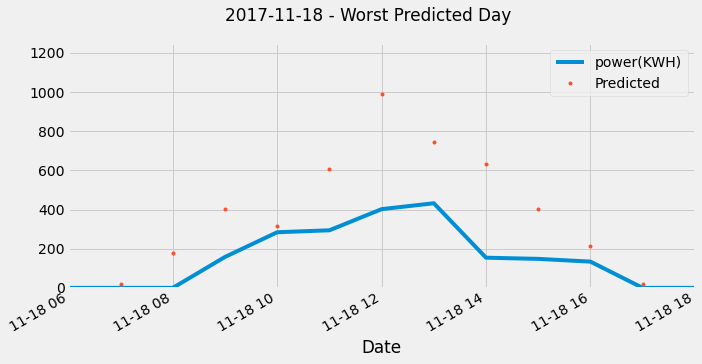

In [15]:
def plot_one(data, day, title):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(10)
    _ = data[['power(KWH)','Predicted']].plot(ax=ax, style=['-','.'])
    ax.set_ylim(0, 1250)
    ax.set_xbound(lower=day+' 06:00', upper=day +' 18:00')
    plot = plt.suptitle(day+ ' - ' + title +' Predicted Day ')

# plot worst day
plot_one(test_days, Worst_date, 'Worst')

Plotting best predicted day.

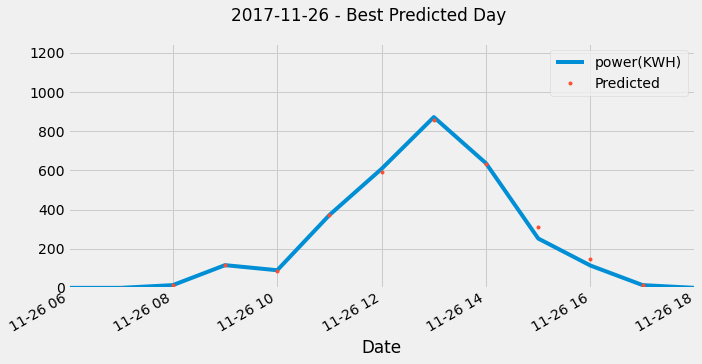

In [16]:
# plot best day
plot_one(test_days, Best_date, 'Best')